# Audio Feature Extraction & Analysis

The aim of this project is to discover what combination of audio features gives the best performance with electronic versus organic source classification. Source recognition is treated as a binary classification problem, with a sound represented as either orginating from a live in-person source or an electronic source. Features extracted by [Essentia](http://essentia.upf.edu/) and [LibROSA](https://librosa.github.io/librosa/), tools for audio analysis and audio-based music information retrieval, were used.

In [1]:
%matplotlib inline  

# essentia
import essentia
from essentia.standard import *
import essentia.standard as es

# librosa
import librosa
import librosa.display

# file support
import os
from os import listdir
from os.path import isfile, join, basename, splitext

# analysis
import IPython
import numpy as np
import pandas as pd
import scipy
import sklearn

# plots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
sns.set_palette("bright")

/usr/local/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/usr/local/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


## Using Existing Feature Results
If you already have a dataset of extracted features that you want to use... 

In [190]:
df_audio = pd.read_csv('features.csv', index_col=0)  

# Feature Extraction

## Parsing in Essentia

In [2]:
def extract_essentia_features(audio):
    features, feature_frames = es.MusicExtractor(
    lowlevelStats=['mean', 'stdev', 'var', 'median', 'skew', 'kurt', 'dmean', 'dvar', 'dmean2', 'dvar2', 'cov', 'icov'],
    rhythmStats=['mean', 'stdev', 'var', 'median', 'skew', 'kurt', 'dmean', 'dvar', 'dmean2', 'dvar2', 'cov', 'icov'],
    tonalStats=['mean', 'stdev', 'var', 'median', 'skew', 'kurt', 'dmean', 'dvar', 'dmean2', 'dvar2', 'cov', 'icov'])(audio)
    
    spectral_df = pd.DataFrame()
    feature_vals = []
    
    for feature in features.descriptorNames():
        if isinstance(features[feature], (float, int)):
            spectral_df[feature] = 0.
            feature_vals.append(features[feature])
        else: break
            
    spectral_df.loc[0] = feature_vals
    
    return spectral_df.fillna(spectral_df.mean())

## Parsing in LibROSA

In [3]:
def create_chroma_df(chroma):
    chroma_mean = np.mean(chroma, axis = 1)
    chroma_std = np.std(chroma, axis = 1)
    
    chroma_df = pd.DataFrame()
    for i in range(0,12):
        chroma_df['chroma ' + str(i) + ' mean'] = chroma_mean[i]
        chroma_df['chroma ' + str(i) + ' std'] = chroma_std[i]
    chroma_df.loc[0] = np.concatenate((chroma_mean, chroma_std), axis = 0)

    return chroma_df

In [4]:
def create_mfccs_df(mfccs):
    mfccs_mean = np.mean(mfccs, axis = 1)
    mfccs_std = np.std(mfccs, axis = 1)
   
    mfccs_df = pd.DataFrame()
    for i in range(0,13):
        mfccs_df['mfccs ' + str(i) + ' mean'] = mfccs_mean[i]
        mfccs_df['mfccs ' + str(i) + ' std'] = mfccs_std[i]
    mfccs_df.loc[0] = np.concatenate((mfccs_mean, mfccs_std), axis = 0)
    
    return mfccs_df

In [23]:
def create_rms_df(rms):
    rms_mean = np.mean(rms)
    rms_std = np.std(rms)
    rms_skew = scipy.stats.skew(rms, axis = 1)[0]
    
    rms_df = pd.DataFrame()
    rms_df['rms mean'] = rms_mean
    rms_df['rms std'] = rms_std
    rms_df['rms skew'] = rms_skew
    rms_df.loc[0] = np.concatenate((rms_mean, rms_std, rms_skew), axis = 0)
    
    return rms_df

In [6]:
def create_spectral_df(cent, contrast, rolloff, flatness):
    
    # spectral centroids values
    cent_mean = np.mean(cent)
    cent_std = np.std(cent)
    cent_skew = scipy.stats.skew(cent, axis = 1)[0]

    # spectral contrasts values
    contrast_mean = np.mean(contrast, axis = 1)
    contrast_std = np.std(contrast, axis = 1)
    
    # spectral rolloff points values
    rolloff_mean = np.mean(rolloff)
    rolloff_std = np.std(rolloff)
    rolloff_skew = scipy.stats.skew(rolloff, axis = 1)[0]
    
    # spectral flatness values
    flat_mean = np.mean(flatness)
    flat_std = np.std(flatness)
    flat_skew = scipy.stats.skew(flatness, axis = 1)[0]

    spectral_df = pd.DataFrame()
    collist = ['cent mean','cent std','cent skew',
               'flat mean', 'flat std', 'flat skew',
               'rolloff mean', 'rolloff std', 'rolloff skew']
    for i in range(0,7):
        collist.append('contrast ' + str(i) + ' mean')
        collist.append('contrast ' + str(i) + ' std')
    
    for c in collist:
        spectral_df[c] = 0
    data = np.concatenate((
        [cent_mean, cent_std, cent_skew], 
        [flat_mean, flat_std, flat_skew],
        [rolloff_mean, rolloff_std, rolloff_skew], 
        contrast_mean, contrast_std),
        axis = 0)
    spectral_df.loc[0] = data
    
    return spectral_df

In [7]:
def create_zrate_df(zrate):
    zrate_mean = np.mean(zrate)
    zrate_std = np.std(zrate)
    zrate_skew = scipy.stats.skew(zrate, axis = 1)[0]

    zrate_df = pd.DataFrame()
    zrate_df['zrate mean'] = 0
    zrate_df['zrate std'] = 0
    zrate_df['zrate skew'] = 0
    zrate_df.loc[0]=[zrate_mean, zrate_std, zrate_skew]
    
    return zrate_df

In [8]:
def create_beat_df(tempo):
    beat_df = pd.DataFrame()
    beat_df['tempo'] = tempo
    beat_df.loc[0] = tempo
    return beat_df

In [9]:
def extract_features(audio):
    y, sr = librosa.load(audio, sr=44100)
    y_harmonic = y
    #y_harmonic, y_percussive = librosa.effects.hpss(y)
    
    tempo, beat_frames = librosa.beat.beat_track(y=y_harmonic, sr=sr)
    beat_times = librosa.frames_to_time(beat_frames, sr=sr)
    beat_time_diff = np.ediff1d(beat_times)
    beat_nums = np.arange(1, np.size(beat_times))
    
    chroma = librosa.feature.chroma_cens(y=y_harmonic, sr=sr)
    
    mfccs = librosa.feature.mfcc(y=y_harmonic, sr=sr, n_mfcc=13)
    
    cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    
    flatness = librosa.feature.spectral_flatness(y=y)
    
    contrast = librosa.feature.spectral_contrast(y=y_harmonic,sr=sr)
    
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    
    zrate = librosa.feature.zero_crossing_rate(y_harmonic)
    
    chroma_df = create_chroma_df(chroma)
    
    mfccs_df = create_mfccs_df(mfccs)
    
    spectral_df = create_spectral_df(cent, contrast, rolloff, flatness)
    
    zrate_df = create_zrate_df(zrate)
    
    beat_df = create_beat_df(tempo)
    
    final_df = pd.concat((chroma_df, mfccs_df, spectral_df, zrate_df, beat_df), axis = 1)
    
    return final_df

## Manual Features: Hum Quantification
Audio files are sometimes contaminated with low-frequency humming tones degrading the audio quality. Typical causes for this problem are the electric installation frequency (aka mains hum; typically 50-60Hz) or poor electrical isolation on the recording or copying equipment. 

This algorithm detects low frequency tonal noises in the audio signal. First, the steadiness of the power spectral density of the signal is computed by measuring the quantile ratios as described in [1]. Then, the `essentia.streaming.PitchContours` algorithm is used to track the humming tones. The features reported are statistical summarizes of the output quantile ratios, frequencies, and saliences. 

[1] Brandt, M., & Bitzer, J. (2014). Automatic Detection of Hum in Audio Signals. Journal of the Audio Engineering Society, 62(9), 584-595.

In [10]:
# dependencies
import essentia.standard as es
import numpy as np
import matplotlib.pyplot as plt
from essentia import Pool
from essentia import db2amp
from IPython.display import Audio 

# an auxiliar function for plotting spectrograms
def spectrogram(audio, frameSize=1024, hopSize=512, db=True):
    eps = np.finfo(np.float32).eps
    window = es.Windowing(size=frameSize)
    spectrum = es.PowerSpectrum(size=frameSize)
    pool = Pool()
    for frame in es.FrameGenerator(audio, frameSize=frameSize, hopSize=hopSize, startFromZero=True):
        pool.add('spectrogram', spectrum(window(frame)))

    if db:
        return 10 * np.log10(pool['spectrogram'].T + eps)
    else:
        return pool['spectrogram'].T   

def generate_hum_plots(audio, matrices, quantiles):
    f, ax = plt.subplots(len(matrices), figsize=(15, 12))
    f0 = 0
    fn = 1000
    fs = 44100.
    out_fs = 2000
    
    for i in range(0, len(matrices)):
        ax[i].imshow(matrices[i], aspect='auto', origin='lower', extent=[0 , matrices[i].shape[1] * .2, f0, fn])
        ax[i].set_title('Q0 = ' + str(quantiles[i][0]) + ', Q1 = ' + str(quantiles[i][1]))
    
    return plt

# hum = discontinuities of frequencies [22.5, 400)
def calculate_hum(audio, quantiles):
    audio_with_hum = es.MonoLoader(filename=audio)()
    quantile_ratios = []
    frequencies = []
    saliences = []
    hum_starts = []
    hum_ends = []
    
    for quantile in quantiles: 
        r, freq, sal, starts, ends = es.HumDetector(Q0=quantile[0], Q1=quantile[1])(audio_with_hum)
        quantile_ratios.append(r)
        frequencies.append(freq)
        saliences.append(sal)
        hum_starts.append(starts)
        hum_ends.append(ends)
    
    return quantile_ratios, frequencies, saliences, hum_starts, hum_ends

def calculate_hum_features(quantiles, ratios, frequencies, saliences, starts, ends):
    features = ['length', 'frequency', 'salience']
    hum_metrics = []
    hum_quartile_vals = []
    
    for q, f, s, ss, es in zip(quantiles, frequencies, saliences, starts, ends):
        # generate dataframe column names
        hum_metrics.append('hum_(Q0='+str(q[0])+',Q1='+str(q[1])+')_instances')
        for feature in features: # per statistical feature
            q_descriptor = 'hum_(Q0='+str(q[0])+',Q1='+str(q[1])+')_'+feature+'.'
            hum_metrics.extend(q_descriptor + metric for metric in ['mean', 'stdev', 'skew'])
        
        # compute statistical features on hum lengths
        hum_lengths = []
        zip_stamps = zip(ss, es)
        q_count = len(ss)
        for start, end in zip_stamps:
            hum_lengths.append(end-start)
        q_length_mean = np.mean(hum_lengths)
        q_length_stdev = np.std(hum_lengths)
        q_length_skew = scipy.stats.skew(hum_lengths)
        
        # compute statistical features on hum frequencies
        q_freq_mean = np.mean(f)
        q_freq_stdev = np.std(f)
        q_freq_skew = scipy.stats.skew(f)
        
        # compute statistical features on hum saliences
        q_sal_mean = np.mean(s)
        q_sal_stdev = np.std(s)
        q_sal_skew = scipy.stats.skew(s)
        
        # add metrics to vector
        hum_quartile_vals.extend((
            q_count, 
            q_length_mean, q_length_stdev, q_length_skew,
            q_freq_mean, q_freq_stdev, q_freq_skew,
            q_sal_mean, q_sal_stdev, q_sal_skew
        ))
        
    hum_dict = dict(zip(hum_metrics, hum_quartile_vals)) # pair column names and values as a dictionary
    hum_df = pd.DataFrame(hum_dict, index=[0]) # convert to data frame
    return hum_df

def extract_hum_features(audio, quantiles):
    rs, freqs, sals, starts, ends = calculate_hum(audio, quantiles)
    #generate_hum_plots(audio, rs, quantiles)
    hum_df = calculate_hum_features(quantiles, rs, freqs, sals, starts, ends).fillna(0)
    return hum_df

## Manual Features: Discontinuity Quantification
Discontinuities occur occasionally by hardware issues in the process of recording or copying. This algorithm described here uses Linear Predictive Coding and some heuristics as described in [1] to detect discontinuities in an audio signal.

[1] Barchiesi, D., Giannoulis, D., Stowell, D., & Plumbley, M. D. (2015). Acoustic scene classification: Classifying environments from the sounds they produce. IEEE Signal Processing Magazine, 32(3), 16-34. 

In [11]:
import essentia.standard as es
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio 
from essentia import array as esarr

# a stand-alone detector method
def compute_discontinuities(audio, frame_size=1024, hop_size=512, **kwargs):
    x = es.MonoLoader(filename=audio)()
    discontinuityDetector = es.DiscontinuityDetector(frameSize=frame_size, hopSize=hop_size, **kwargs)
    locs = []
    amps = []
    for idx, frame in enumerate(es.FrameGenerator(x, frameSize=frame_size, hopSize=hop_size, startFromZero=True)):
        frame_locs, frame_ampls = discontinuityDetector(frame)

        for l in frame_locs:
            locs.append((l + hop_size * idx) / 44100.)
        for a in frame_ampls:
            amps.append(a)

    return locs, amps

def generate_discontinuity_plot(locs, audio):
    fs = 44100.
    x = es.MonoLoader(filename=audio)()
    fig, ax = plt.subplots(len(locs))
    plt.subplots_adjust(hspace=.4)
    times = np.linspace(0, len(x) / fs, len(x))
    for idx, point in enumerate(locs):
        ax[idx].axvline(locs[idx], color='black', alpha=.25)
        ax[idx].plot(times, x)
        ax[idx].set_xlim([point-.001, point+.001])
        ax[idx].set_title('Click located at {:.2f}s'.format(point))
    
    return plt

def calculate_discontinuity_features(locs, amps):
    dis_metrics = {
        'discontinuity_instances': len(locs), 
        'discontinuity_locations.mean': np.mean(locs),
        'discontinuity_locations.stdev': np.std(locs),
        'discontinuity_locations.skew': scipy.stats.skew(locs),
        'discontinuity_amplitudes.mean': np.mean(amps),
        'discontinuity_amplitudes.stdev': np.std(amps),
        'discontinuity_amplitudes.skew': scipy.stats.skew(amps)
    }
    
    dis_df = pd.DataFrame(dis_metrics, index=[0]) # convert to data frame
    return dis_df

def extract_discontinuity_features(audio):
    locs, amps = compute_discontinuities(audio)
    dis_df = calculate_discontinuity_features(locs, amps).fillna(0)
    return dis_df

## Manual Features: Click Quantification
An extension of the discontinuties detection algorithm, this algorithm detects the locations of impulsive noises (such as clicks and pops) on the input audio frame. It relies on LPC coefficients to perform an inverse-filter on the audio to attenuate the stationary part and enhance the prediction error (or excitation noise). See [1] for more information. Then, a matched filter is used to further enhance the impulsive peaks. The detection threshold is obtained from a robust estimate of the excitation noise power [2] plus a parametric gain value.

[1] Vaseghi, S. V., & Rayner, P. J. W. (1990). Detection and suppression of impulsive noise in speech communication systems. IEE Proceedings I (Communications, Speech and Vision), 137(1), 38-46.

[2] Vaseghi, S. V. (2008). Advanced digital signal processing and noise reduction. John Wiley & Sons. Page 355.

In [12]:
import essentia.standard as es
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio 
from essentia import array as esarr

# a stand-alone detector method
def compute_clicks(audio, frame_size=1024, hop_size=512, **kwargs):
    x = es.MonoLoader(filename=audio)()
    clickDetector = es.ClickDetector(frameSize=frame_size, hopSize=hop_size, **kwargs)
    ends = []
    starts = []
    for frame in es.FrameGenerator(x, frameSize=frame_size,
                                   hopSize=hop_size, startFromZero=True):
        frame_starts, frame_ends = clickDetector(frame)

        for s in frame_starts:
            starts.append(s)
        for e in frame_ends:
            ends.append(e)

    return starts, ends

def generate_clicks_plot(starts, ends, audio):
    fs = 44100.
    x = es.MonoLoader(filename=audio)()

    times = np.linspace(0, len(x) / fs, len(x))
    plt.plot(times, x)
    for point_s, point_e in zip(starts, ends):
        #l1 = plt.axvline(point_s, color='red', alpha=.5)
        #l2 = plt.axvline(point_e, color='blue', alpha=.5)
        l1 = plt.axvspan(point_s, point_e, alpha=0.5, color='red')

    l1.set_label('Click locations')
    #l1.set_label('Click starts')
    #l2.set_label('Click ends')
    plt.legend()
    return plt

def calculate_clicks_features(starts, ends):
    durations = []
    for s, e in zip(starts, ends):
        duration = e - s
        durations.append(duration)
        
    clicks_metrics = {
        'clicks_instances': len(starts), 
        'clicks_starts.mean': np.mean(starts),
        'clicks_starts.stdev': np.std(starts),
        'clicks_starts.skew': scipy.stats.skew(starts),
        'clicks_durations.mean': np.mean(durations),
        'clicks_durations.stdev': np.std(durations),
        'clicks_durations.skew': scipy.stats.skew(durations)
    }
    
    clicks_df = pd.DataFrame(clicks_metrics, index=[0]) # convert to data frame
    return clicks_df

def extract_clicks_features(audio):
    starts, ends = compute_clicks(audio)
    clicks_df = calculate_clicks_features(starts, ends).fillna(0)
    return clicks_df

#audio = "audio/Electronic/musicbox.wav"
#clicks_df = extract_clicks_features(audio)
#clicks_df.head()
#starts, ends = compute_clicks(audio)
#generate_clicks_plot(starts, ends, audio)

## Manual Extraction: Energy Balance Metrics

In [41]:
# output the ebm calculation for a single file as a dataframe (e.g., column: 'ebm')
def extract_ebm_features(audio):
    
    ebm_metrics = {
        'ebm.value': float(audio), 
        'ebm.lower_bound': 20,
        'ebm.upper_bound': 250
    }
    
    ebm_df = pd.DataFrame(ebm_metrics, index=[0])
    return ebm_df

#extract_ebm_features("path/to/test_file")

## Extracting Frequency Band

In [26]:
from scipy.signal import freqz, butter, lfilter
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def plot_order_frequency_reponses(lowcut, highcut, fs, orders):
    plt.clf()
    for order in orders:
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        w, h = freqz(b, a, worN=2000)
        plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

    plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
             '--', label='sqrt(0.5)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain')
    plt.grid(True)
    plt.legend(loc='best')
    return plt

def plot_effect(original, filtered, fs):
    plt.figure(figsize=(15, 5))
    librosa.display.waveplot(original, sr=fs, alpha=0.25)
    librosa.display.waveplot(filtered, sr=fs, color='red', alpha=0.5)
    plt.title("Original + Filtered Signals")
    return plt

def filter_signal(signal, lowcut, highcut, write_output = '', fs=44100.0):
    y = butter_bandpass_filter(signal, lowcut, highcut, fs, order=2)
    if write_output: 
        try: 
            sf.write(write_output, y, fs)
        except Exception as e:
            print("Cannot write to", write_output, ". Invalid file name passed.")
    return y

# EXAMPLES
# audio = "audio/Electronic/human_rights.mp3"
# lowcut = 250.0 # minimum frequency cutoff (Hz)
# highcut = 550.0 # maximum frequency cutoff (Hz)
# original, fs = librosa.load(audio)

# plot the frequency response for a few different orders.
# plot_order_frequency_reponses(lowcut, highcut, fs, [1, 2, 3]).show()

# filtered = filter_signal(original, lowcut, highcut, 'audio/tests/test.wav')
# plot_effect(original, filtered, fs).show()

### Auxiliary Functions

In [28]:
def remove_extension(file):
    return os.path.splitext(file)[0]

def path_leaf(path):
    head, tail = os.path.split(path)
    return tail or os.path.basename(head)

def generate_file_name(outDir, inFile, lowcut, highcut, suffix = "_filtered", extension = ".wav"):
    return outDir + remove_extension(path_leaf(inFile)) + '_' + str(int(lowcut)) + '-' + str(int(highcut)) + suffix + extension

def extract_freq_band(inputAudio, lowcut, highcut, outputDir):
    original, fs = librosa.load(inputAudio)
    filtered = filter_signal(original, lowcut, highcut, outputDir, fs)
    return filtered

def get_files(directory, valid_exts):
    return ([directory + x for x in 
       [f for f in listdir(directory) if (isfile(join(directory, f)) # get files only
       and bool([ele for ele in valid_exts if(ele in f)])) ]         # with valid extension
      ])  

## Putting it all together

In [57]:
def extract_dir_overall_features(
    directory,   # parent directory of main audio files
    extensions,  # filter directory by file extensions
    target,      # directory represents which class
    mono_read = False, mono_parse = False, # mono-tize files
    filter_band = False, filter_directory = '', filter_lowcut = 20.0, filter_highcut = 250.0): 
    
    all_features = []
    files = []
    if mono_read: # get only files with mono in name
        files = [i for i in get_files(directory, extensions) if "_mono" in i]
    else: # get all files without mono
        files = [i for i in get_files(directory, extensions) if not "_mono" in i]
    
    # get EBM values
    EBM_values = pd.DataFrame()
    if (target == 0):
        EBM_values = pd.read_csv("electronicEBMs.csv", delimiter=',', index_col=0, names = ['filename', 'ebmVal'])
    else: EBM_values = pd.read_csv("organicEBMs.csv", delimiter=',', index_col=0, names = ['filename', 'ebmVal'])

    print('\nReading directory', directory)
    for file in files:
        print('\tParsing features from', file)
        try:
            # determine target and identifier
            print('\t\t generating row identifiers')
            description = pd.DataFrame({
                'id':[file.split('/')[-1].split('.')[0]],
                'target':[target]
            }, index=[0])

            # preprocessing here
            curr_file = file
            if mono_parse: # will parse and create mono file
                print('\t\t parsing file for mono conversion')
                y, _ = librosa.load(file, sr=44100.)
                mono_stream = librosa.core.to_mono(y)
                mono_filename = directory + remove_extension(path_leaf(file)) + "_mono.wav"
                print('\t\t saving file for mono file as', mono_filename)
                sf.write(mono_filename, mono_stream, 44100)
                curr_file = mono_filename
                print('\t\t finished mono parsing')
            
            # extract sub-band features
            filtered_features = pd.DataFrame()
            if filter_band:
                print('\t\t extracting frequency band from', curr_file)
                loc = generate_file_name(filter_directory, file, filter_lowcut, filter_highcut)
                extract_freq_band(file, filter_lowcut, filter_highcut, loc)
                print('\t\t saving frequency band as', loc)
                filtered_features = pd.concat(
                    (extract_features(loc), 
                     extract_essentia_features(loc), 
                     #extract_hum_features(loc, [[.1, .55], [.1, .25], [.1, .75]]),
                     #extract_discontinuity_features(loc), 
                     #extract_clicks_features(loc),
                    ), axis = 1).add_prefix('band_')
                print('\t\t finished extracting features from frequency band')
            
            # extract overall spectra features
            overall_features = pd.concat(
                (description,
                 extract_features(curr_file), 
                 extract_essentia_features(curr_file), 
                 #extract_hum_features(curr_file, [[.1, .55], [.1, .25], [.1, .75]]),
                 #extract_discontinuity_features(curr_file), 
                 #extract_clicks_features(curr_file),
                 #extract_ebm_features(EBM_values.loc[os.path.basename(curr_file), "ebmVal"]),
                 filtered_features
                ), axis = 1)
            print('\t\t finished extracting features from overall spectrum')
            
            # add to feature list
            all_features.append(overall_features)
        except Exception as e:
            print(e)
            
    return all_features

# get overall features with mono-tize preprocessing step
electronic_features_mono = pd.concat(extract_dir_overall_features("audio/Electronic/", ['.mp3', '.wav', '.flac'], 0, False, True, True, 'audio/tests/Electronic/'))
organic_features_mono = pd.concat(extract_dir_overall_features("audio/Organic/", ['.mp3', '.wav', '.flac'], 1, False, True, True, 'audio/tests/Organic/'))
df_audio = pd.concat([electronic_features_mono, organic_features_mono], axis = 0)

# get overall features on all files (mono + stereo)
# o_electronic_features_stereo = extract_dir_overall_features("audio/Electronic/", ['.mp3', '.wav', '.flac'], 0)
# o_organic_features = extract_dir_overall_features("audio/Organic/", ['.mp3', '.wav', '.flac'], 1)

print('DONE.')


Reading directory audio/Electronic/
	Parsing features from audio/Electronic/shopElecD.wav
		 generating row identifiers
		 parsing file for mono conversion
		 saving file for mono file as audio/Electronic/shopElecD_mono.wav
		 finished mono parsing
		 extracting frequency band from audio/Electronic/shopElecD_mono.wav
		 saving frequency band as audio/tests/Electronic/shopElecD_20-250_filtered.wav
		 finished extracting features from frequency band
		 finished extracting features from overall spectrum
	Parsing features from audio/Electronic/musicbox.wav
		 generating row identifiers
		 parsing file for mono conversion
		 saving file for mono file as audio/Electronic/musicbox_mono.wav
		 finished mono parsing
		 extracting frequency band from audio/Electronic/musicbox_mono.wav
		 saving frequency band as audio/tests/Electronic/musicbox_20-250_filtered.wav
		 finished extracting features from frequency band
		 finished extracting features from overall spectrum
	Parsing features from audi

'\ndf2 = pd.DataFrame(np.random.randn(10, 5))\ndf3 = pd.DataFrame(np.random.randn(10, 5))\ndf1 = pd.concat([df2, df3], axis = 0)\ndf1.head()\n'

# Understanding the Feature Set

In [61]:
df_audio.describe()

,target,chroma 0 mean,chroma 0 std,chroma 1 mean,chroma 1 std,chroma 2 mean,chroma 2 std,chroma 3 mean,chroma 3 std,chroma 4 mean,...,band_tonal.key_krumhansl.strength,band_tonal.key_temperley.strength,band_tonal.tuning_diatonic_strength,band_tonal.tuning_equal_tempered_deviation,band_tonal.tuning_frequency,band_tonal.tuning_nontempered_energy_ratio,rhythm.beats_loudness.max,rhythm.beats_loudness.min,band_rhythm.beats_loudness.max,band_rhythm.beats_loudness.min
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,...,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,1.0,1.0,2.0,2.0
mean,0.500000,0.259771,0.275628,0.297557,0.287977,0.263024,0.244017,0.234480,0.249766,0.269665,...,0.463614,0.456613,0.346820,0.241053,442.848424,0.890689,0.0,0.0,0.0,0.0
std,0.522233,0.039051,0.044869,0.034151,0.048986,0.062367,0.048503,0.042403,0.053069,0.047830,...,0.083619,0.081093,0.083179,0.050293,7.948663,0.042991,NaN,NaN,0.0,0.0
min,0.000000,0.201519,0.230011,0.254478,0.222530,0.170709,0.159031,0.153684,0.137367,0.203838,...,0.300881,0.286498,0.213675,0.106520,431.941772,0.772034,0.0,0.0,0.0,0.0
25%,0.000000,0.233586,0.235650,0.268321,0.252132,0.217153,0.222221,0.203581,0.222589,0.238877,...,0.424744,0.419869,0.280461,0.229602,436.204163,0.882385,0.0,0.0,0.0,0.0
50%,0.500000,0.258963,0.278534,0.285488,0.284189,0.260391,0.241195,0.238363,0.267840,0.270317,...,0.465923,0.453040,0.348394,0.240122,441.273804,0.890182,0.0,0.0,0.0,0.0
75%,1.000000,0.286247,0.293438,0.320312,0.328180,0.305405,0.273665,0.266266,0.284190,0.300982,...,0.504300,0.496933,0.400901,0.271051,450.089478,0.911556,0.0,0.0,0.0,0.0
max,1.000000,0.331196,0.371990,0.365507,0.376479,0.396205,0.323485,0.294337,0.317326,0.339518,...,0.623338,0.616278,0.467186,0.297032,455.253540,0.948193,0.0,0.0,0.0,0.0


## Compare sub-band to overall spectra

In [65]:
df_band = pd.concat((df_audio[['id']], df_audio.filter(regex='^band_',axis=1)), axis = 1)
df_band.columns = df_band.columns.str.replace('^band_', '')
df_band.head()

,id,chroma 0 mean,chroma 0 std,chroma 1 mean,chroma 1 std,chroma 2 mean,chroma 2 std,chroma 3 mean,chroma 3 std,chroma 4 mean,...,tonal.hpcp_entropy.var,tonal.key_edma.strength,tonal.key_krumhansl.strength,tonal.key_temperley.strength,tonal.tuning_diatonic_strength,tonal.tuning_equal_tempered_deviation,tonal.tuning_frequency,tonal.tuning_nontempered_energy_ratio,rhythm.beats_loudness.max,rhythm.beats_loudness.min
0,shopElecD,0.251725,0.240391,0.307027,0.358193,0.285843,0.270754,0.260335,0.275791,0.305171,...,0.702185,0.486623,0.484250,0.452902,0.329679,0.263415,454.465302,0.908209,NaN,NaN
0,musicbox,0.191719,0.357339,0.257621,0.274394,0.405919,0.287139,0.220723,0.177854,0.210463,...,0.275661,0.622855,0.623338,0.616278,0.467186,0.106520,444.341888,0.772034,NaN,NaN
0,stopElecD,0.250619,0.266049,0.318259,0.353583,0.272929,0.291811,0.265980,0.270228,0.257405,...,0.745222,0.495016,0.483554,0.509345,0.384906,0.231277,436.204163,0.893215,0.0,0.0
0,closeElecD,0.244145,0.272849,0.278302,0.246439,0.223149,0.241568,0.259308,0.301517,0.332291,...,0.770975,0.442859,0.448291,0.453178,0.440855,0.293828,436.204163,0.925085,NaN,NaN
0,hello_google_ElecD,0.233822,0.305973,0.374070,0.301160,0.241169,0.197132,0.184200,0.227781,0.289355,...,0.868884,0.471563,0.447986,0.420725,0.367109,0.228044,442.293365,0.881354,NaN,NaN


In [66]:
# calculate differences between sub-bass and overall spectra
df_differences = df_audio.set_index('id').subtract(df_band.set_index('id'), fill_value = 0)
df_differences.to_csv('features_differences.csv', index = True)
df_differences.describe()

,band_cent mean,band_cent skew,band_cent std,band_chroma 0 mean,band_chroma 0 std,band_chroma 1 mean,band_chroma 1 std,band_chroma 10 mean,band_chroma 10 std,band_chroma 11 mean,...,tonal.key_edma.strength,tonal.key_krumhansl.strength,tonal.key_temperley.strength,tonal.tuning_diatonic_strength,tonal.tuning_equal_tempered_deviation,tonal.tuning_frequency,tonal.tuning_nontempered_energy_ratio,zrate mean,zrate skew,zrate std
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,...,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,1548.047513,-0.289126,646.245768,0.273526,0.306637,0.331398,0.306777,0.081939,0.081626,0.076438,...,0.004230,0.011359,0.013743,0.090546,-0.001350,-0.039441,-0.008134,0.269401,0.207238,0.184766
std,469.549415,0.792684,273.163013,0.043111,0.044541,0.045004,0.051676,0.042349,0.039014,0.019348,...,0.063916,0.057582,0.051412,0.084869,0.022882,9.462573,0.030978,0.087036,0.472088,0.059751
min,277.186006,-1.475669,31.805410,0.191719,0.240391,0.257621,0.225231,0.030416,0.036741,0.045555,...,-0.123385,-0.098141,-0.074125,-0.090002,-0.042815,-19.267822,-0.051091,0.011026,-0.111077,0.009073
25%,1470.083924,-0.759030,533.881412,0.249000,0.271149,0.308032,0.264005,0.059164,0.052939,0.059804,...,-0.040440,-0.025276,-0.028346,0.022713,-0.010467,-1.687210,-0.032356,0.267677,-0.094562,0.174252
50%,1659.277475,-0.247848,632.428945,0.267944,0.305401,0.330010,0.322408,0.074417,0.069770,0.080580,...,0.005023,0.013155,0.022430,0.127543,-0.001881,-0.124710,-0.015179,0.282062,0.013038,0.195594
75%,1778.725632,0.159485,783.739228,0.317152,0.326289,0.347650,0.349781,0.089908,0.111867,0.092839,...,0.053019,0.048658,0.050623,0.140747,0.012277,0.819008,0.007432,0.308596,0.218007,0.218665
max,2055.271334,1.191459,1120.737462,0.331515,0.399301,0.428887,0.366262,0.188390,0.163658,0.103928,...,0.081777,0.098391,0.092718,0.202165,0.039228,16.203339,0.043017,0.357870,1.402033,0.236946


In [67]:
# see what features contribute most to the sub-band difference
df_differences.abs().mean().sort_values().tail(10)

lowlevel.spectral_spread.median        7.812155e+06
lowlevel.spectral_rolloff.dvar         1.108710e+07
lowlevel.spectral_rolloff.dvar2        2.195300e+07
lowlevel.spectral_rolloff.var          7.827042e+07
lowlevel.spectral_spread.dvar2         2.957821e+12
lowlevel.spectral_spread.dvar          3.761433e+12
band_lowlevel.spectral_spread.dvar     4.047892e+12
band_lowlevel.spectral_spread.dvar2    4.116157e+12
band_lowlevel.spectral_spread.var      8.245006e+12
lowlevel.spectral_spread.var           4.239539e+13
dtype: float64

### Correlations between Independent Features

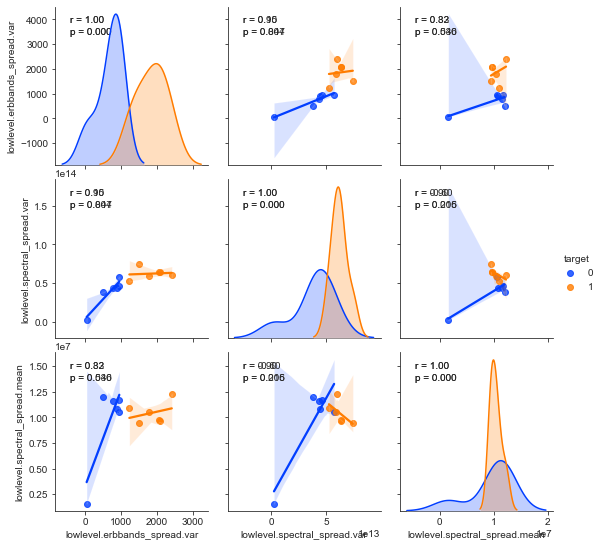

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, ttest_ind

def corrfunc(x, y, **kws):
    (r, p) = pearsonr(x, y) # pearson coefficient with two-sided pvalue
    #tt, pval = ttest_ind(x, y)  # t-statistic for mean, two-sided pvalue = Prob(abs(t)>tt)
    ax = plt.gca()
    ax.annotate("r = {:.2f} ".format(r),
                xy=(.1, .9), xycoords=ax.transAxes, fontsize=10)
    ax.annotate("p = {:.3f}".format(p),
                xy=(.1, .825), xycoords=ax.transAxes, fontsize=10)

graph = sns.pairplot(
    df_audio, 
    hue="target", 
    vars=['lowlevel.erbbands_spread.var', 'lowlevel.spectral_spread.var', 'lowlevel.spectral_spread.mean'],
    kind="reg"
)

graph.map(corrfunc)
plt.show()

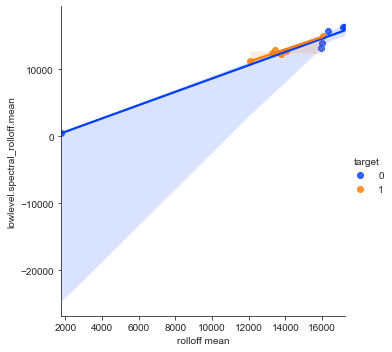

In [73]:
sns.lmplot('rolloff mean', 'lowlevel.spectral_rolloff.mean', hue ='target', data = df_audio, fit_reg=True)
#sns.scatterplot(x = 'ebm.value', y = 'lowlevel.barkbands_crest.mean', hue = 'target', data = df_audio)

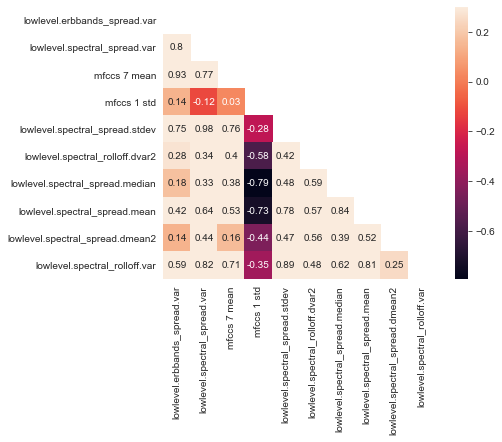

In [72]:
highlighted_features = df_audio[['lowlevel.erbbands_spread.var', 'lowlevel.spectral_spread.var', 'mfccs 7 mean', 'mfccs 1 std', 'lowlevel.spectral_spread.stdev', 'lowlevel.spectral_rolloff.dvar2', 'lowlevel.spectral_spread.median', 'lowlevel.spectral_spread.mean', 'lowlevel.spectral_spread.dmean2', 'lowlevel.spectral_rolloff.var']]
corr = highlighted_features.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, annot=True)

### Building a Classifier (Example)
Here we implement a ML algorithm and evaluate its performance using different training and testing datasets.

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.60      1.00      0.75         3

    accuracy                           0.67         6
   macro avg       0.80      0.67      0.62         6
weighted avg       0.80      0.67      0.62         6



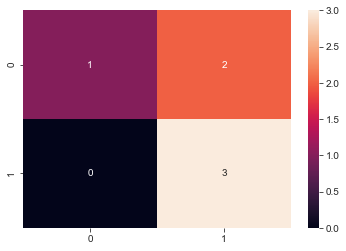

In [74]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics

df_audio.fillna(df_audio.mean(), inplace=True) # replace NaN/infinite values
X = df_audio.drop(['target', 'id'], axis = 1).values
y = df_audio['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, #df_audio.drop(['target', 'id'], axis=1), # feature values per sample
    y, #df_audio['target'], # target labels per sample
    test_size=0.5,            # 50% test/ 50% training; proportion of the dataset to include in the test split
    random_state=109          # controls the shuffling applied to the data before applying split
)

classifier = svm.SVC(kernel='linear', probability=True) # create a SVM classifier with a linear kernel
classifier.fit(X_train, y_train)      # train model using the training sets
y_pred = classifier.predict(X_test)   # predict the response for test dataset

confusion = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(confusion, annot=True)

print(metrics.classification_report(y_test, y_pred))

### Evaluating Performance using K-fold Cross Validation
Cross validation can be used to estimate the performance of a ML algorithm with less variance than a single train-test set split. The K-fold method splits the dataset into k-parts (aka folds). The algorithm is trained on k-1 folds with one fold saved for testing. 

This splitting process is repeated so that each fold of the dataset is given a chance to be the test set. The cross validation returns k performance scores that can be summarized using a mean and a standard deviation. Because the algorithm is trained and evaluated multiple times on different datasets, this result is a more reliable estimate of the performance of an algorithm.

In [75]:
from sklearn import model_selection, linear_model
from sklearn.linear_model import LogisticRegression

seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)
model = LogisticRegression()
results = model_selection.cross_val_score(model, X, y, cv=kfold)
print("Distribution:", results)
print("Accuracy (mean): %.3f%% \n Accuracy (std): %.3f%%" % (results.mean()*100.0, results.std()*100.0))

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Distribution: [0. 1. 0. 0. 1. 1. 1. 1. 0. 0.]
Accuracy (mean): 50.000% 
 Accuracy (std): 50.000%


### Evaluating Performance with Leave One Out Cross Validation
Configuring cross validation so that the size of the fold is 1 (k = number of samples in the dataset), makes this a leave-one-out cross validation. The result is several performance measures that can be summarized to give a reasonable estimate of the accuracy of your model on unseen data. However, it's more computationally expensive than k-fold cross validation. 

In [76]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

num_folds = 10
loocv = model_selection.LeaveOneOut()
model = LogisticRegression()
results = model_selection.cross_val_score(model, X, y, cv=loocv)
print("Distribution:", results)
print("Accuracy (mean): %.3f%% \n Accuracy (std): %.3f%%" % (results.mean()*100.0, results.std()*100.0))

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Distribution: [0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0.]
Accuracy (mean): 50.000% 
 Accuracy (std): 50.000%


### Evaluating Performance using Repeated Random Test-Train Splits
Another k-fold cross validation variation involves creating a random split of the data (such as that made in the train/test split above, but the process is repeated on splitting and evaluating the algorithm multiple times (like cross validation). 

This method has the speed of using a simple train/test split and a reduction in standard deviation in estimated performance of a k-fold cross validation. However, the down side of these repetitions is that they may include much of the same data in the train/test split from run to run, therefore introducing redundancy into the evaluation.

The example below splits the data into a 75%/25% train/test split and repeats the process 10 times.

In [77]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

test_size = 0.25
seed = 7
kfold = model_selection.ShuffleSplit(n_splits=10, test_size=test_size, random_state=seed)
model = LogisticRegression()
results = model_selection.cross_val_score(model, X, y, cv=kfold)
print("Distribution:", results)
print("Accuracy (mean): %.3f%% \n Accuracy (std): %.3f%%" % (results.mean()*100.0, results.std()*100.0))

Distribution: [0.66666667 0.66666667 0.66666667 0.66666667 0.33333333 0.66666667
 0.66666667 0.33333333 0.33333333 0.66666667]
Accuracy (mean): 56.667% 
 Accuracy (std): 15.275%


### ROC Curves
Another popular method for evaluating classifer output quality. ROC (Receiver Operating Characteristic) curves typically feature true positive rates on the Y and false positive rates on the X axis. This means that the top left corner of the plot is the "ideal" (a false positive rate = 0 and true positive rate = 1). Although this is not very realistic, a larger area under the curve (AUC) is preferred. 

No Skill: ROC AUC=0.500
Logistic: ROC AUC=1.000


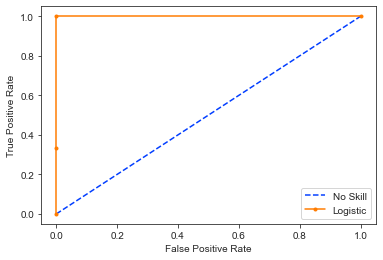

In [78]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# predict probabilities
lr_probs = classifier.predict_proba(X_test)

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### Precision-Recall Curve
Where the ROC curves summarize the trade-off between the true positive and false positive rates for a classifier using different probability thresholds, the precision-recall curve summarizes the trade-off between the true positive rate and the positive predictive value for a classifier using different probability thresholds. 

Logistic: f1=0.750 auc=1.000


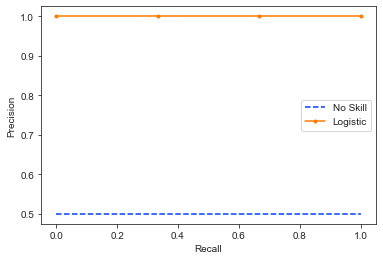

In [79]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

# predict probabilities
lr_probs = classifier.predict_proba(X_test)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# predict class values
y_hat = classifier.predict(X_test)

# calculate precision and recall for each threshold
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)

# calculate scores
lr_f1, lr_auc = f1_score(y_test, y_hat), auc(lr_recall, lr_precision)

# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

### Deciding which performance evaluation techniques to use when
- **k-fold** cross validation is considered the gold-standard for evaluating the performance of a ML algorithm on unseen data with *k* set to 3, 5, or 10. 
- **train/test** splitting is good for speed when the ML algorithm is slow. This technique also produces performance estimates with lower bias when using large datasets.
- **leave-one-out** cross validation and **repeated random splits** are useful intermediates when trying to balance variance in estimated performance results, model training size, and dataset size.
- When in doubt, use a **10-fold cross validation**
- **ROC** curves are appropriate when the observations are balanced between each class whereas **precision-recall** curves are more appropriate for more imbalanced datasets. 

# Classifiers

In [81]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = df_audio.drop(['target', 'id'], axis = 1).values
y = df_audio['target']

X = StandardScaler().fit_transform(X)
X_Train, X_Test, y_Train, y_Test = train_test_split(X, y, test_size = 0.50, random_state = 101)

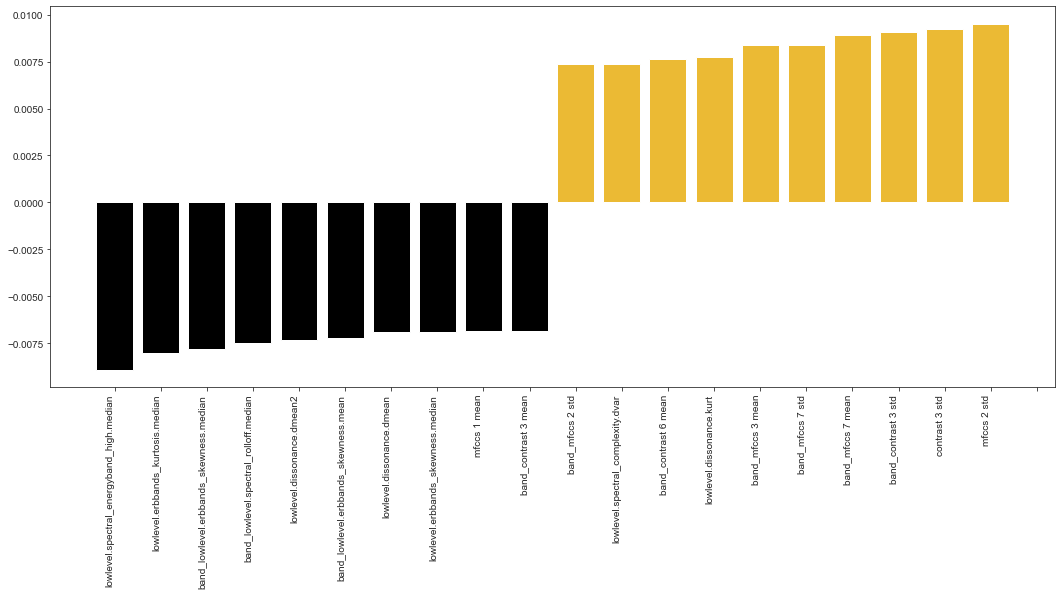

In [84]:
# Preprocessing :
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix
from itertools import product

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

### Logistic Regression

In [33]:
trainedmodel = LogisticRegression().fit(X_Train, y_Train)
predictions = trainedmodel.predict(X_Test)
print(confusion_matrix(y_Test,predictions))
print(classification_report(y_Test,predictions))

[[4 0]
 [0 3]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         3

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7



### Random Forest

In [34]:
trainedforest = RandomForestClassifier(n_estimators=700).fit(X_Train, y_Train)
predictionforest = trainedforest.predict(X_Test)
print(confusion_matrix(y_Test,predictionforest))
print(classification_report(y_Test,predictionforest))

[[4 0]
 [0 3]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         3

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7



### SVMs

In [35]:
trainedsvm = svm.LinearSVC().fit(X_Train, y_Train)
predictionsvm = trainedsvm.predict(X_Test)
print(confusion_matrix(y_Test,predictionsvm))
print(classification_report(y_Test,predictionsvm))

[[4 0]
 [0 3]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         3

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7



### Decision Tree

In [36]:
trainedtree = tree.DecisionTreeClassifier().fit(X_Train, y_Train)
predictionstree = trainedtree.predict(X_Test)
print(confusion_matrix(y_Test,predictionstree))
print(classification_report(y_Test,predictionstree))

[[3 1]
 [1 2]]
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.67      0.67      0.67         3

    accuracy                           0.71         7
   macro avg       0.71      0.71      0.71         7
weighted avg       0.71      0.71      0.71         7



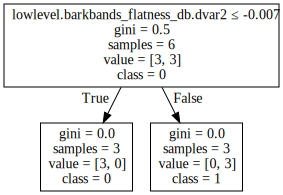

In [37]:
import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz

data = export_graphviz(
    trainedtree,out_file = None,
    feature_names = df_audio.drop(['target', 'id'], axis = 1).columns,
    class_names = ['0', '1'], 
    max_depth = 5,
    special_characters = True
)
graph = graphviz.Source(data)
graph

### Linear Discriminant Analysis

In [38]:
trainedlda = LinearDiscriminantAnalysis().fit(X_Train, y_Train)
predictionlda = trainedlda.predict(X_Test)
print(confusion_matrix(y_Test,predictionlda))
print(classification_report(y_Test,predictionlda))

[[3 1]
 [0 3]]
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.75      1.00      0.86         3

    accuracy                           0.86         7
   macro avg       0.88      0.88      0.86         7
weighted avg       0.89      0.86      0.86         7



### Naive Bayes

In [39]:
trainednb = GaussianNB().fit(X_Train, y_Train)
predictionnb = trainednb.predict(X_Test)
print(confusion_matrix(y_Test,predictionnb))
print(classification_report(y_Test,predictionnb))

[[2 2]
 [2 1]]
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         4
           1       0.33      0.33      0.33         3

    accuracy                           0.43         7
   macro avg       0.42      0.42      0.42         7
weighted avg       0.43      0.43      0.43         7



### XGBoost

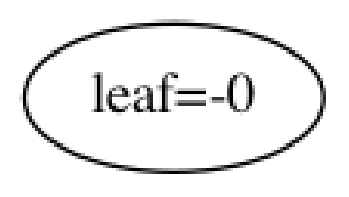

<Figure size 3600x3600 with 0 Axes>

In [40]:
from xgboost import XGBClassifier
from xgboost import plot_tree
import matplotlib.pyplot as plt
model = XGBClassifier()

model.fit(X_Train, y_Train)

plot_tree(model)
plt.figure(figsize = (50,50))
plt.show()

[[4 0]
 [3 0]]
              precision    recall  f1-score   support

           0       0.57      1.00      0.73         4
           1       0.00      0.00      0.00         3

    accuracy                           0.57         7
   macro avg       0.29      0.50      0.36         7
weighted avg       0.33      0.57      0.42         7



/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


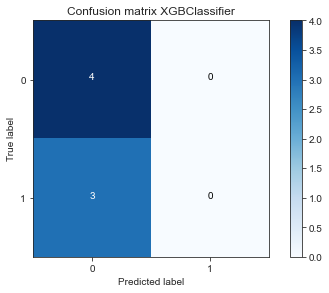

In [41]:
from itertools import product
import itertools

predictions = model.predict(X_Test)
print(confusion_matrix(y_Test,predictions))
print(classification_report(y_Test,predictions))

# Thanks to: https://www.kaggle.com/tejainece/data-visualization-and-machine-learning-algorithms
def plot_confusion_matrix(cm, classes=["0", "1"], title="",
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix ' +title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm_plot = confusion_matrix(y_Test,predictions)

plt.figure()
plot_confusion_matrix(cm_plot, title = 'XGBClassifier')

# Feature Engineering

In [85]:
# Preprocessing :
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, f1_score, auc
from itertools import product
from sklearn import model_selection

names = [
    'Nearest Neighbors', 
    'Linear SVM', 
    'RBF SVM',
    'Gaussian Process', 
    'Decision Tree', 
    'Random Forest', 
    'Neural Net', 
    'AdaBoost', 
    'Naive Bayes', 
    'QDA'
]
classifiers = [
    KNeighborsClassifier(3), # number of neighbors = 3
    SVC(kernel='linear', C=0.025), # linear kernel with regularization/misclassification error = 0.025
    SVC(gamma=2, C=0.025), # looser SVM with higher regularization
    GaussianProcessClassifier(1.0 * RBF(1.0)), # RBF kernel
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1), # estimators = # of trees in the forest, max_features = # of features to consider when looking for best split
    MLPClassifier(alpha=0.025, max_iter=1000), # multilayer perceptron with L2 penalty/regularization = 1, max_iter = limit as solver iterates until convergence
    AdaBoostClassifier(), 
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]

X = df_audio.drop(['target', 'id'], axis = 1).values
y = df_audio['target']
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.5, random_state=42)

scores = []
accuracy_vals = []
recall_vals = []
specificity_vals = []
precision_vals = []
false_positive_rates = []
false_negative_rates = []
cv_means = []
cv_stds = []
no_skill_aucs = []
logistic_aucs = []
prc_aucs = []
prc_f1_scores = []
lr_precisions = []
lr_recalls = []

for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    
    score = clf.score(X_test, y_test)
    scores.append(score)
    
    y_hat = clf.predict(X_test)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
    accuracy_vals.append((tn + tp) / (tn + fp + fn + tp))
    recall_vals.append(tp / (fn + tp))
    specificity_vals.append(tn / (tn + fp))
    precision_vals.append(tp / (fp + tp))
    false_positive_rates.append(fp / (tn + fp))
    false_negative_rates.append(fn / (fn + tp))
    # print(classification_report(Y_Test,predictionnb))
    
    kfold = model_selection.KFold(n_splits=10)
    cv_score = model_selection.cross_val_score(clf, X, y, cv=kfold)
    cv_means.append(cv_score.mean() * 100.0)
    cv_stds.append(cv_score.std() * 100.0)
    
    lr_probs_roc = classifier.predict_proba(X_test)
    ns_probs_roc = [0 for _ in range(len(y_test))]
    lr_probs_roc = lr_probs_roc[:, 1]
    ns_auc_roc = roc_auc_score(y_test, ns_probs_roc)
    lr_auc_roc = roc_auc_score(y_test, lr_probs_roc)
    no_skill_aucs.append(ns_auc_roc)
    logistic_aucs.append(lr_auc_roc)
    # calculate roc curves
    #ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    #lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs_roc)
    lr_precisions.append(lr_precision)
    lr_recalls.append(lr_recall)
    lr_f1_prc, lr_auc_prc = f1_score(y_test, y_hat), auc(lr_recall, lr_precision)
    prc_aucs.append(lr_auc_prc)
    prc_f1_scores.append(lr_f1_prc)
    no_skill = len(y_test[y_test==1]) / len(y_test)
    
df_performance = pd.DataFrame({
    'classifier': names, 
    'score': scores, 
    'accuracy': accuracy_vals, 
    'recall': recall_vals,
    'specificity': specificity_vals,
    'precision': precision_vals,
    'FPR': false_positive_rates,
    'FNR': false_negative_rates, 
    'CV-10 mean': cv_means,
    'CV-10 std': cv_stds, 
    'No Skill ROC AUC': no_skill_aucs,
    'Logistic ROC AUC': logistic_aucs,
    'Precision-Recall AUC': prc_aucs,
    'F1': prc_f1_scores
})

df_performance.describe()

/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/site-packages/sklearn/discriminan

,score,accuracy,recall,specificity,precision,FPR,FNR,CV-10 mean,CV-10 std,No Skill ROC AUC,Logistic ROC AUC,Precision-Recall AUC,F1
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.000000,1.000000e+01,10.000000
mean,0.633333,0.633333,0.833333,0.433333,0.651667,0.566667,0.166667,55.000000,35.556700,0.5,0.888889,9.166667e-01,0.702857
std,0.172133,0.172133,0.175682,0.386501,0.208233,0.386501,0.175682,29.439203,16.011145,0.0,0.000000,1.170278e-16,0.110291
min,0.333333,0.333333,0.666667,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.5,0.888889,9.166667e-01,0.500000
25%,0.500000,0.500000,0.666667,0.083333,0.500000,0.333333,0.000000,41.250000,34.011716,0.5,0.888889,9.166667e-01,0.666667
50%,0.666667,0.666667,0.833333,0.333333,0.600000,0.666667,0.166667,52.500000,40.311289,0.5,0.888889,9.166667e-01,0.708333
75%,0.791667,0.791667,1.000000,0.666667,0.729167,0.916667,0.333333,78.750000,46.274677,0.5,0.888889,9.166667e-01,0.787500
max,0.833333,0.833333,1.000000,1.000000,1.000000,1.000000,0.333333,95.000000,50.000000,0.5,0.888889,9.166667e-01,0.857143


In [86]:
df_performance.head()

,classifier,score,accuracy,recall,specificity,precision,FPR,FNR,CV-10 mean,CV-10 std,No Skill ROC AUC,Logistic ROC AUC,Precision-Recall AUC,F1
0,Nearest Neighbors,0.666667,0.666667,1.000000,0.333333,0.6,0.666667,0.000000,75.0,40.311289,0.5,0.888889,0.916667,0.750000
1,Linear SVM,0.500000,0.500000,1.000000,0.000000,0.5,1.000000,0.000000,85.0,32.015621,0.5,0.888889,0.916667,0.666667
2,RBF SVM,0.500000,0.500000,1.000000,0.000000,0.5,1.000000,0.000000,0.0,0.000000,0.5,0.888889,0.916667,0.666667
3,Gaussian Process,0.833333,0.833333,0.666667,1.000000,1.0,0.000000,0.333333,80.0,40.000000,0.5,0.888889,0.916667,0.800000
4,Decision Tree,0.833333,0.833333,0.666667,1.000000,1.0,0.000000,0.333333,50.0,50.000000,0.5,0.888889,0.916667,0.800000


Text(0, 0.5, 'True Positive Rate')

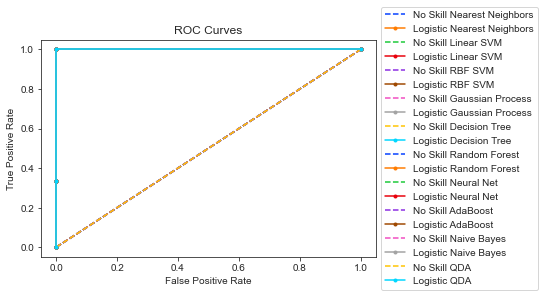

In [87]:
# show ROC curves
for name, ns_auc, log_auc in zip(names, no_skill_aucs, logistic_aucs):
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill ' + name)
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic ' + name)

plt.title('ROC Curves')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

Text(0, 0.5, 'Precision')

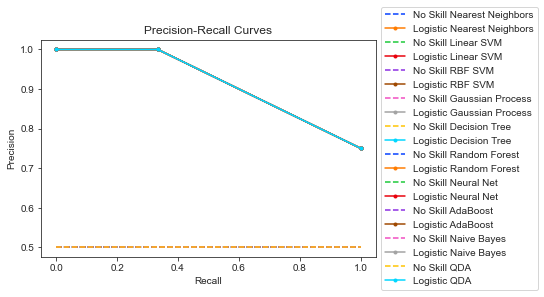

In [88]:
# show Precision-Recall curves
for name, precision, recall in zip(names, lr_precisions, lr_recalls):
    no_skill = len(y_test[y_test==1]) / len(y_test)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill ' + name)
    plt.plot(lr_recall, lr_precision, marker='.', label='Logistic ' + name)

plt.title('Precision-Recall Curves')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Recall')
plt.ylabel('Precision')

### Classifer on reduced feature sets

In [89]:
pca = PCA(n_components=2,svd_solver='full')
X_pca = pca.fit_transform(X)
#print(pca.explained_variance_)

X_reduced, X_test_reduced, Y_Train, Y_Test = train_test_split(
    X_pca, 
    y, 
    #df_audio.drop(['target', 'id'], axis=1),         # feature values per sample
    #df_audio['target'],       # target labels per sample
    test_size = 0.30, 
    random_state = 101)

# pca = PCA(n_components=2,svd_solver='full')
# X_reduced = pca.fit_transform(X_Train)
# X_reduced = TSNE(n_components=2).fit_transform(X_Train, Y_Train)

trainednb = GaussianNB().fit(X_reduced, Y_Train)
trainedsvm = svm.LinearSVC().fit(X_reduced, Y_Train)
trainedforest = RandomForestClassifier(n_estimators=700).fit(X_reduced,Y_Train)
trainedmodel = LogisticRegression().fit(X_reduced,Y_Train)

# pca = PCA(n_components=2,svd_solver='full')
# X_test_reduced = pca.fit_transform(X_Test)
# X_test_reduced = TSNE(n_components=2).fit_transform(X_Test, Y_Test)

print('Naive Bayes')
predictionnb = trainednb.predict(X_test_reduced)
print(confusion_matrix(Y_Test,predictionnb))
print(classification_report(Y_Test,predictionnb))

print('SVM')
predictionsvm = trainedsvm.predict(X_test_reduced)
print(confusion_matrix(Y_Test,predictionsvm))
print(classification_report(Y_Test,predictionsvm))

print('Random Forest')
predictionforest = trainedforest.predict(X_test_reduced)
print(confusion_matrix(Y_Test,predictionforest))
print(classification_report(Y_Test,predictionforest))

print('Logistic Regression')
predictions =trainedmodel.predict(X_test_reduced)
print(confusion_matrix(Y_Test,predictions))
print(classification_report(Y_Test,predictions))

/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Naive Bayes
[[0 2]
 [0 2]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.50      1.00      0.67         2

    accuracy                           0.50         4
   macro avg       0.25      0.50      0.33         4
weighted avg       0.25      0.50      0.33         4

SVM
[[0 2]
 [0 2]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.50      1.00      0.67         2

    accuracy                           0.50         4
   macro avg       0.25      0.50      0.33         4
weighted avg       0.25      0.50      0.33         4

Random Forest
[[0 2]
 [0 2]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.50      1.00      0.67         2

    accuracy                           0.50         4
   macro avg       0.25      0.50      0.33         4

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


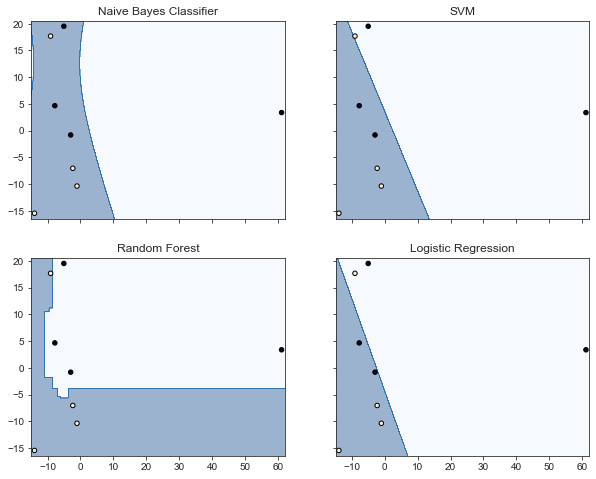

In [90]:
reduced_data = X_reduced

trainednb = GaussianNB().fit(reduced_data, Y_Train)
trainedsvm = svm.LinearSVC().fit(reduced_data, Y_Train)
trainedforest = RandomForestClassifier(n_estimators=700).fit(reduced_data,Y_Train)
trainedmodel = LogisticRegression().fit(reduced_data,Y_Train)

x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [trainednb, trainedsvm, trainedforest, trainedmodel],
                        ['Naive Bayes Classifier', 'SVM',
                         'Random Forest', 'Logistic Regression']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, cmap=plt.cm.Blues, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(reduced_data[:, 0], reduced_data[:, 1], c=Y_Train,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

### Linear Discriminant Analysis

In [94]:
# Load libraries
from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Create an LDA that will reduce the data down to 1 feature
lda = LinearDiscriminantAnalysis(n_components=1)

# run an LDA and use it to transform the features
X_lda = lda.fit(X, y).transform(X)

# Print the number of features
print('Original number of features:', X.shape[1])
print('Reduced number of features:', X_lda.shape[1])

## View the ratio of explained variance
print(lda.explained_variance_ratio_)

X_reduced, X_test_reduced, Y_Train, Y_Test = train_test_split(X_lda, y, test_size = 0.30, random_state = 101)

trainednb = GaussianNB().fit(X_reduced, Y_Train)
trainedsvm = svm.LinearSVC().fit(X_reduced, Y_Train)

print('Naive Bayes')
predictionnb = trainednb.predict(X_test_reduced)
print(confusion_matrix(Y_Test,predictionnb))
print(classification_report(Y_Test,predictionnb))

print('SVM')
predictionsvm = trainedsvm.predict(X_test_reduced)
print(confusion_matrix(Y_Test,predictionsvm))
print(classification_report(Y_Test,predictionsvm))

Original number of features: 1102
Reduced number of features: 1
[1.]
Naive Bayes
[[1 1]
 [0 2]]
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.67      1.00      0.80         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4

SVM
[[1 1]
 [0 2]]
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.67      1.00      0.80         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4



### t-SNE

In [95]:
from sklearn.manifold import TSNE
import time

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 11 nearest neighbors...
[t-SNE] Indexed 12 samples in 0.000s...
[t-SNE] Computed neighbors for 12 samples in 0.044s...
[t-SNE] Computed conditional probabilities for sample 12 / 12
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.650616
[t-SNE] KL divergence after 300 iterations: 0.299645
t-SNE done! Time elapsed: 0.6450090408325195 seconds


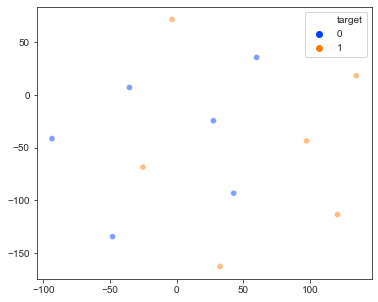

In [96]:
plt.figure(figsize=(6,5))
sns.scatterplot(
    x = tsne_results[:,0], y=tsne_results[:,1],
    hue = y,
    palette = sns.color_palette("bright", 2),
    data = df_audio,
    legend = "full",
    alpha = 0.5
)

## Clustering

In [97]:
pca = PCA(n_components=2,svd_solver='full')
X_pca = pca.fit_transform(X)

print('PCA Explained Variance: ', pca.explained_variance_)
print('Original number of features:', X.shape[1])
print('Reduced number of features:', X_pca.shape[1])
print('PCA Explained Variance Ratio: ', pca.explained_variance_ratio_)

X_reduced, X_test_reduced, Y_Train, Y_Test = train_test_split(X_pca, y, test_size = 0.30, random_state = 101)

PCA Explained Variance:  [395.17169427 152.41180429]
Original number of features: 1102
Reduced number of features: 2
PCA Explained Variance Ratio:  [0.33885942 0.130693  ]


### K-Means

In [98]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_reduced)
kpredictions = kmeans.predict(X_test_reduced)
print(confusion_matrix(Y_Test,kpredictions))
print(classification_report(Y_Test,kpredictions))

[[2 0]
 [2 0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       0.00      0.00      0.00         2

    accuracy                           0.50         4
   macro avg       0.25      0.50      0.33         4
weighted avg       0.25      0.50      0.33         4



/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


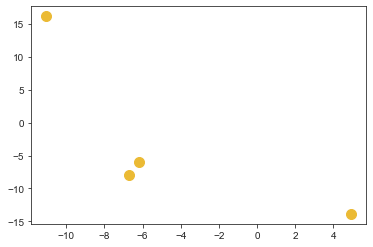

In [99]:
plt.scatter(X_test_reduced[kpredictions ==0,0], X_test_reduced[kpredictions == 0,1], s=100, c='#ebba34')
plt.scatter(X_test_reduced[kpredictions ==1,0], X_test_reduced[kpredictions == 1,1], s=100, c='#000000')

### Hierarchical Clustering

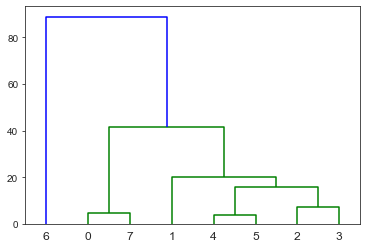

In [100]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

# create dendrogram
dendrogram = sch.dendrogram(sch.linkage(X_reduced, method='ward'))

# create clusters
hc = AgglomerativeClustering(n_clusters=2, affinity = 'euclidean', linkage = 'ward')

# save clusters for chart
hierarchicalpredictions = hc.fit_predict(X_test_reduced)

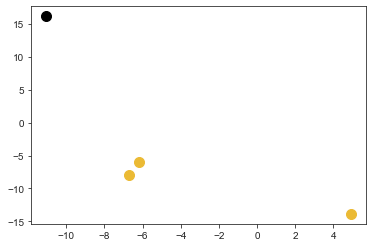

In [101]:
plt.scatter(X_test_reduced[hierarchicalpredictions ==0,0], X_test_reduced[hierarchicalpredictions == 0,1], s=100, c='#ebba34')
plt.scatter(X_test_reduced[hierarchicalpredictions ==1,0], X_test_reduced[hierarchicalpredictions == 1,1], s=100, c='#000000')

### Deep Learning

In [102]:
from keras.utils.np_utils import to_categorical
Y_Train = to_categorical(Y_Train)

Using TensorFlow backend.


In [103]:
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers.core import Dense, Activation, Dropout
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, BatchNormalization, Activation

#Y_Test = to_categorical(Y_Test)

input_dim = X_Train.shape[1]
nb_classes = Y_Train.shape[1]

# Here's a Deep Dumb MLP (DDMLP)
model = Sequential()
model.add(Dense(512, input_dim=input_dim))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.15))
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.15))
model.add(Dense(nb_classes))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))

# we'll use categorical xent for the loss, and RMSprop as the optimizer
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

print("Training...")
model.fit(X_Train, Y_Train, nb_epoch=50, batch_size=16, validation_split=0.1, verbose=80)

preds = model.predict_classes(X_Test, verbose=0)

Training...


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


ValueError: Input arrays should have the same number of samples as target arrays. Found 6 input samples and 8 target samples.

In [73]:
print(confusion_matrix(Y_Test,preds))
print(classification_report(Y_Test,preds))

NameError: name 'preds' is not defined

# Feature Selection

In [104]:
import pandas as pd
import numpy as np

X = df_audio.drop(['target', 'id'], axis=1)
y = df_audio['target']
df_audio.head()

,id,target,chroma 0 mean,chroma 0 std,chroma 1 mean,chroma 1 std,chroma 2 mean,chroma 2 std,chroma 3 mean,chroma 3 std,...,band_tonal.key_krumhansl.strength,band_tonal.key_temperley.strength,band_tonal.tuning_diatonic_strength,band_tonal.tuning_equal_tempered_deviation,band_tonal.tuning_frequency,band_tonal.tuning_nontempered_energy_ratio,rhythm.beats_loudness.max,rhythm.beats_loudness.min,band_rhythm.beats_loudness.max,band_rhythm.beats_loudness.min
0,shopElecD,0,0.243305,0.230011,0.287332,0.330020,0.315236,0.296909,0.273156,0.299079,...,0.484250,0.452902,0.329679,0.263415,454.465302,0.908209,0.0,0.0,0.0,0.0
0,musicbox,0,0.201519,0.371990,0.283644,0.268219,0.396205,0.282843,0.221039,0.181522,...,0.623338,0.616278,0.467186,0.106520,444.341888,0.772034,0.0,0.0,0.0,0.0
0,stopElecD,0,0.205839,0.236225,0.320094,0.300159,0.273919,0.323485,0.294337,0.276164,...,0.483554,0.509345,0.384906,0.231277,436.204163,0.893215,0.0,0.0,0.0,0.0
0,closeElecD,0,0.234768,0.231966,0.268712,0.257481,0.232000,0.237588,0.255687,0.317326,...,0.448291,0.453178,0.440855,0.293828,436.204163,0.925085,0.0,0.0,0.0,0.0
0,hello_google_ElecD,0,0.230041,0.235581,0.320969,0.319369,0.261492,0.241125,0.215653,0.226952,...,0.447986,0.420725,0.367109,0.228044,442.293365,0.881354,0.0,0.0,0.0,0.0


## Univariate Selection
The scikit-learn library provides the `SelectKBest` class that can be use to select the *n* features that have the strongest relationship with the output variable. The example below uses the chi-squared statistical test for sum of squares of independent features that have a standard normal distribution to select 10 of the most important features from the dataset.

The chi-squared statistic seems to work in a hand-wavy way with non-negative numerical and categorical features.

In [105]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

# apply SelectKBest class to extract top 10 best features
chi_selector = SelectKBest(score_func=chi2, k=10)
# chi-2 X values cannot be negative
# fit = chi_selector.fit(X,y)
# dfscores = pd.DataFrame(fit.scores_)

X_norm = MinMaxScaler().fit_transform(X)
fit_norm = chi_selector.fit(X_norm,y)
dfcolumns = pd.DataFrame(X.columns)
dfscores_norm = pd.DataFrame(fit_norm.scores_)
chi_support = chi_selector.get_support()

# concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns, dfscores_norm],axis=1)
featureScores.columns = ['Features', 'Normalized Score']  # naming the dataframe columns
print(featureScores.nlargest(10, 'Normalized Score'))  # print 10 best features'''

                                         Features  Normalized Score
357      lowlevel.spectral_energyband_high.median          2.349731
587                             band_mfccs 7 mean          2.338032
165             lowlevel.erbbands_kurtosis.median          1.981118
66                                 contrast 3 std          1.979077
504        rhythm.bpm_histogram_first_peak_weight          1.942857
323             lowlevel.spectral_complexity.dvar          1.931278
615                           band_contrast 3 std          1.893509
620                          band_contrast 6 mean          1.859740
420                lowlevel.spectral_kurtosis.var          1.849647
1053  band_rhythm.bpm_histogram_first_peak_weight          1.813953


## ExtraTrees
Using feature importance class already built into tree-based classifiers

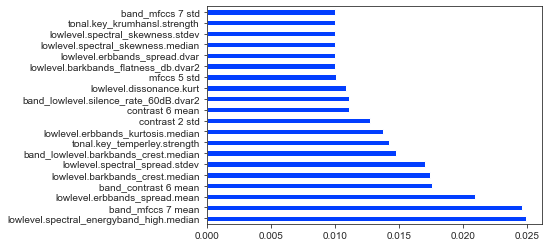

In [106]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

model = ExtraTreesClassifier()
model.fit(X, y)

# plot feature importances
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.nlargest(20).plot(kind='barh')
plt.show()

## Pearson Correlation
A filter-based feature selection method in which we check the absolute value of the Pearson's correlation between the target and numerical features in our dataset. We keep the top n features based on this criterion. 

In [107]:
num_feats = 10 # number of features to select
pearson_corrs = []
feature_names = X.columns.tolist()

# calculate the correlation of each feature with target
for f in feature_names:
    pearson_corr = np.corrcoef(X[f], y)[0, 1]
    pearson_corrs.append(pearson_corr)

# replace NaN with 0
pearson_corrs = [0 if np.isnan(i) else i for i in pearson_corrs]

# feature name
selected_features = X.iloc[:,np.argsort(np.abs(pearson_corrs))[-num_feats:]].columns.tolist()

# feature support
cor_support = [True if i in selected_features else False for i in feature_names]

# feature selection
allFeatureScores = pd.DataFrame({'feature': X.columns, 'score': pearson_corrs})
featureScores = allFeatureScores.loc[allFeatureScores.feature.isin(selected_features)]

print(featureScores)

/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


                               feature     score
38                        mfccs 7 mean  0.839143
64                      contrast 2 std  0.809205
71                     contrast 6 mean  0.854630
165  lowlevel.erbbands_kurtosis.median -0.834898
187     lowlevel.erbbands_spread.stdev  0.793641
188       lowlevel.erbbands_spread.var  0.850191
586                   band_mfccs 6 std  0.783600
587                  band_mfccs 7 mean  0.926622
588                   band_mfccs 7 std  0.826301
620               band_contrast 6 mean  0.788972


## Recursive Feature Elimination
This wrapper based method considers the selection of a set of features as a search problem.From the `sklearn` documention: "The goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a `coef_` attribute or through a `feature_importances_` attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached."

We could use any estimator with this method. In this example, we use `LogisticRegression` where the RFE method observes the `coef_` attribute of the `LogisticRegression` object.

In [108]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=10, step=10, verbose=5)
rfe_selector.fit(X, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

featureScores = pd.DataFrame({'feature': rfe_feature, 'score': rfe_selector.estimator_.coef_[0]})
print(featureScores)

Fitting estimator with 1102 features.
Fitting estimator with 1092 features.
Fitting estimator with 1082 features.
Fitting estimator with 1072 features.
Fitting estimator with 1062 features.
Fitting estimator with 1052 features.
Fitting estimator with 1042 features.
Fitting estimator with 1032 features.
Fitting estimator with 1022 features.
Fitting estimator with 1012 features.
Fitting estimator with 1002 features.
Fitting estimator with 992 features.
Fitting estimator with 982 features.
Fitting estimator with 972 features.
Fitting estimator with 962 features.
Fitting estimator with 952 features.
Fitting estimator with 942 features.
Fitting estimator with 932 features.
Fitting estimator with 922 features.
Fitting estimator with 912 features.
Fitting estimator with 902 features.
Fitting estimator with 892 features.
Fitting estimator with 882 features.
Fitting estimator with 872 features.
Fitting estimator with 862 features.
Fitting estimator with 852 features.
Fitting estimator with 842 

## LASSO
This is an embedded method that uses algorithms that have built-in feature selection methods (e.g., Lasso's L1 norm as regularizer). The Lasso norm regularizer, unlike [ridge regression](https://en.wikipedia.org/wiki/Tikhonov_regularization), forces a feature weights to zero. See penalty and solver options: [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

In [109]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

lr_selector = SelectFromModel(estimator=LogisticRegression(penalty='l2', solver='newton-cg'), max_features=10)
lr_selector.fit(X, y)
lr_support = lr_selector.get_support()
lr_feature = X.loc[:,lr_support].columns.tolist()

allFeatureScores = pd.DataFrame({'feature': X.columns, 'score': lr_selector.estimator_.coef_[0]})
featureScores = allFeatureScores.loc[allFeatureScores.feature.isin(lr_feature)]

print(featureScores)

                                  feature         score
453         lowlevel.spectral_spread.dvar  4.141323e-10
454        lowlevel.spectral_spread.dvar2 -4.577515e-10
460          lowlevel.spectral_spread.var  8.282455e-12
1002   band_lowlevel.spectral_spread.dvar -2.676189e-09
1003  band_lowlevel.spectral_spread.dvar2  1.248118e-09
1009    band_lowlevel.spectral_spread.var  5.084708e-10


/usr/local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


## RandomForest Feature Selection
An embedded method that calculates feature importance using node impurities (average of all decision tree feature importances) in each decision tree.

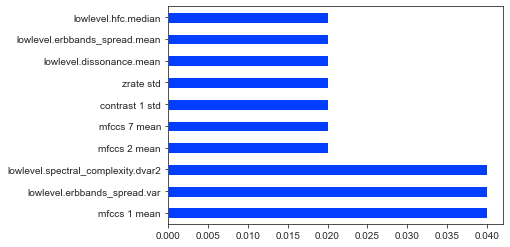

In [110]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=10)
rf_selector.fit(X, y)
rf_support = rf_selector.get_support()
rf_feature = X.loc[:,rf_support].columns.tolist()
#print(rf_feature)

model = RandomForestClassifier(n_estimators=100)
model.fit(X, y)
#print(model.feature_importances_)

# plot feature importances
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.nlargest(10).plot(kind='barh')
plt.show()

## LightGBM Feature Selection
We could also have used a LightGBM or XGBoost or any tree-based classifier with the `feature_importances_` attribute.

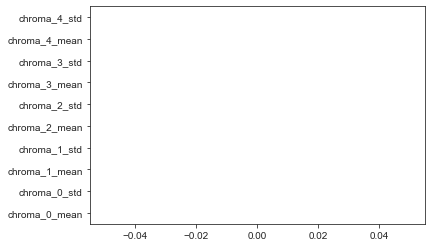

In [111]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

# hm... why is everything 0?
X.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X.columns]
lgbc = LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)
lgbc.fit(X, y)

lgb_selector = SelectFromModel(lgbc, max_features=10)
lgb_selector.fit(X, y)
lgb_support = lgb_selector.get_support()
lgb_feature = X.loc[:,lgb_support].columns.tolist()

importances = pd.Series(lgbc.feature_importances_, index=X.columns)
importances.nlargest(10).plot(kind='barh')

## Feature Plot

/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


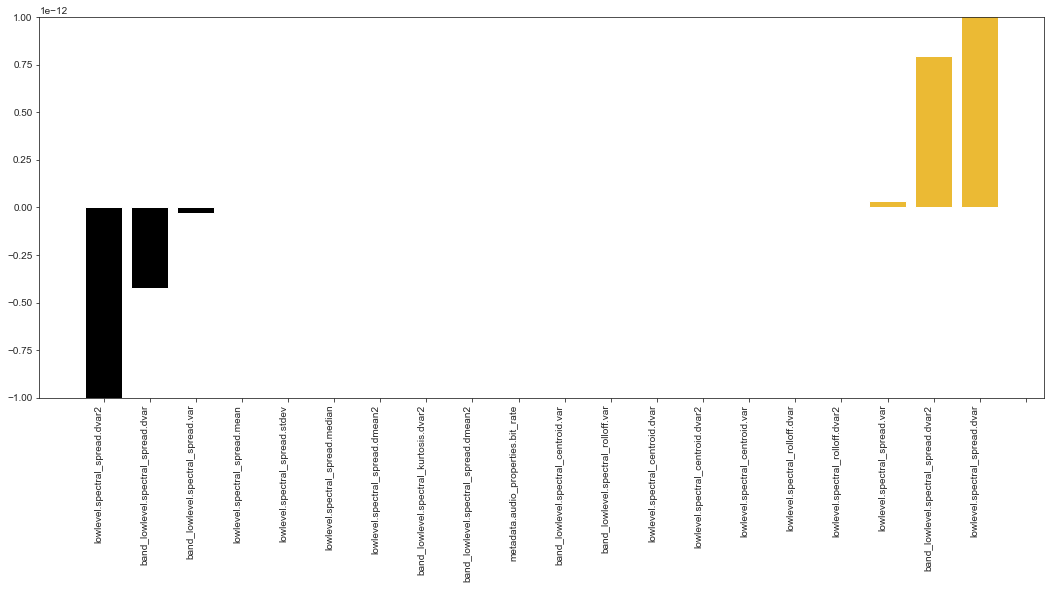

In [112]:
from sklearn import svm
import matplotlib.pyplot as plt

def feature_plot(classifier, feature_names, top_features=4):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    plt.figure(figsize=(18, 7))
    colors = ['#000000' if c < 0 else '#ebba34' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1 + 2 * top_features), feature_names[top_coefficients], rotation=90, ha='right')
    plt.show()

trainedsvm = svm.LinearSVC().fit(X, y)
feature_plot(
    trainedsvm,
    df_audio.drop(['target', 'id'], axis = 1).columns.values, 
    10
)

## Feature Selection: All of 'em
Because why use just one, when we can have them all? (other than time and space constraints of course)

In [113]:
num_feats = 10
# put all selection together
feature_selection_df = pd.DataFrame(
    {'Feature': X.columns, 
     'Pearson': cor_support, 
     'Chi-2': chi_support, 
     'RFE': rfe_support, 
     'Logistics': lr_support,
     'Random Forest': rf_support, 
     'LightGBM': lgb_support
    })

# count the selected times for each feature
feature_selection_df['Count'] = np.sum(feature_selection_df, axis=1)

# display
feature_selection_df = feature_selection_df.sort_values(['Count', 'Feature'], ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df) + 1)
feature_selection_df.head(20)

,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,LightGBM,Count
1,lowlevel_spectral_spread_var,False,False,True,True,False,False,2
2,lowlevel_spectral_spread_dvar2,False,False,True,True,False,False,2
3,lowlevel_spectral_spread_dvar,False,False,True,True,False,False,2
4,lowlevel_spectral_complexity_dvar,False,True,False,False,True,False,2
5,lowlevel_erbbands_spread_var,True,False,False,False,True,False,2
6,lowlevel_erbbands_kurtosis_median,True,True,False,False,False,False,2
7,band_mfccs_7_mean,True,True,False,False,False,False,2
8,band_lowlevel_spectral_spread_var,False,False,True,True,False,False,2
9,band_lowlevel_spectral_spread_dvar2,False,False,True,True,False,False,2
10,band_lowlevel_spectral_spread_dvar,False,False,True,True,False,False,2
